In [49]:
import os, sys, subprocess

def ensure_py(stem: str):
    ipynb, py = f"{stem}.ipynb", f"{stem}.py"
    if not os.path.exists(py) and os.path.exists(ipynb):
        subprocess.run(["jupyter", "nbconvert", "--to", "python", ipynb], check=True)
        with open(py, "r", encoding="utf-8") as f:
            lines = f.readlines()
        fut = [l for l in lines if l.strip().startswith("from __future__")]
        oth = [l for l in lines if l not in fut]
        with open(py, "w", encoding="utf-8") as f:
            f.writelines(fut + oth)

for m in ["acc_env", "attacks"]:
    ensure_py(m)

if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

from acc_env import ACCEnv           # env with CBF clamp inside step()
from attacks import FGSMAttack, OIAttack
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import numpy as np, math
import matplotlib.pyplot as plt


In [50]:
LOGDIR  = "runs/ppo_baseline"
VECPATH = os.path.join(LOGDIR, "vecnormalize.pkl")
MDLPATH = os.path.join(LOGDIR, "ppo_acc.zip")
os.makedirs(LOGDIR, exist_ok=True)

def reset_unwrap(env, **kw):
    out = env.reset(**kw)
    if isinstance(out, tuple) and len(out)==2: return out[0]
    return out

def step_unwrap(env, action):
    out = env.step(action)
    if len(out)==5:
        obs, r, term, trunc, info = out
        return obs, r, bool(term), bool(trunc), info
    elif len(out)==4:
        obs, r, done, info = out
        return obs, r, bool(done), False, info
    raise RuntimeError(f"Unexpected step() length: {len(out)}")

def info_dict(info):
    if isinstance(info, dict): return info
    if hasattr(info, "__len__") and len(info)>0: return info[0]
    return {}

def make_env_train(seed=42):
    def _thunk():
        return ACCEnv(brake_profile=False, normalize_obs=False, seed=seed)
    return _thunk

def make_env_eval(seed=123):
    def _thunk():
        return ACCEnv(brake_profile=True, normalize_obs=False, seed=seed,
                      brake_start_s=3.0, brake_dur_s=4.0, lead_decel=-3.0)
    return _thunk

if os.path.exists(VECPATH) and os.path.exists(MDLPATH):
    base_eval = DummyVecEnv([make_env_eval(123)])
    env = VecNormalize.load(VECPATH, base_eval)
    env.training = False
    env.norm_reward = False
    model = PPO.load(MDLPATH, env=env)
    print(f"Loaded PPO+VecNormalize from {LOGDIR}")
else:
    print(f"Saved files not found in {LOGDIR}. Quick-training (~8k steps).")
    base_train = DummyVecEnv([make_env_train(42)])
    train_env  = VecNormalize(base_train, norm_obs=True, norm_reward=True, clip_obs=1.0)
    model = PPO("MlpPolicy", train_env, verbose=0, seed=42,
                n_steps=512, batch_size=128, learning_rate=3e-4,
                gamma=0.99, gae_lambda=0.95, clip_range=0.2, ent_coef=0.0)
    model.learn(total_timesteps=8_000)
    base_eval = DummyVecEnv([make_env_eval(123)])
    env = VecNormalize(base_eval, norm_obs=True, norm_reward=False, clip_obs=1.0)
    env.obs_rms = train_env.obs_rms
    env.ret_rms = train_env.ret_rms
    env.training = False
    print("Quick-train complete.")


Loaded PPO+VecNormalize from runs/ppo_baseline


In [51]:
def run_episode(mdl, venv, attacker=None, eps=0.01, max_steps=None):
    obs = reset_unwrap(venv)
    total_r, collided, steps = 0.0, 0, 0
    traj = {"Δx": [], "v": [], "a": [], "r": []}
    rmse_terms = []

    while True:
        orig_obs = obs
        obs_adv = attacker.perturb(orig_obs) if attacker else orig_obs
        d = np.asarray(obs_adv) - np.asarray(orig_obs)     # stealth measured pre-step
        rmse_terms.append(float((d**2).mean()))

        action, _ = mdl.predict(obs_adv, deterministic=True)
        obs, r, term, trunc, info = step_unwrap(venv, action)
        r_scalar = float(r[0]) if hasattr(r, "__len__") else float(r)
        total_r += r_scalar

        dct = info_dict(info)
        traj["Δx"].append(dct.get("Δx", math.nan))
        traj["v"].append(dct.get("v",  math.nan))
        traj["a"].append(dct.get("a",  math.nan))
        traj["r"].append(r_scalar)

        if dct.get("collision", False) or (not np.isnan(traj["Δx"][-1]) and traj["Δx"][-1] <= 0.0):
            collided = 1

        steps += 1
        if term or trunc or (max_steps is not None and steps >= max_steps):
            break

    jerk = float(np.mean(np.abs(np.diff(traj["a"])))) if len(traj["a"])>1 else 0.0
    rmse = float(np.sqrt(np.mean(rmse_terms))) if rmse_terms else 0.0
    return {"return": total_r, "collision": collided, "jerk": jerk, "rmse": rmse, "traj": traj}

def evaluate_condition(attacker_cls=None, eps=0.01, episodes=20, base_seed=100):
    rets, cols, jerks, rmses = [], [], [], []
    sample = None
    for i in range(episodes):
        seed = base_seed + i
        base = DummyVecEnv([make_env_eval(seed)])
        venv = VecNormalize.load(VECPATH, base) if os.path.exists(VECPATH) else base
        if isinstance(venv, VecNormalize):
            venv.training=False; venv.norm_reward=False
        mdl = PPO.load(MDLPATH, env=venv) if os.path.exists(MDLPATH) else model
        attacker = attacker_cls(mdl, epsilon=eps, device="cpu") if attacker_cls else None
        res = run_episode(mdl, venv, attacker=attacker, eps=eps)
        rets.append(res["return"]); cols.append(res["collision"]); jerks.append(res["jerk"]); rmses.append(res["rmse"])
        if sample is None: sample = res
    return {
        "returns": np.array(rets, dtype=float),
        "collisions": np.array(cols, dtype=float),
        "jerks": np.array(jerks, dtype=float),
        "rmses": np.array(rmses, dtype=float),
        "sample": sample,
    }


collisions (Baseline): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collisions (FGSM)    : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collisions (OIA)     : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


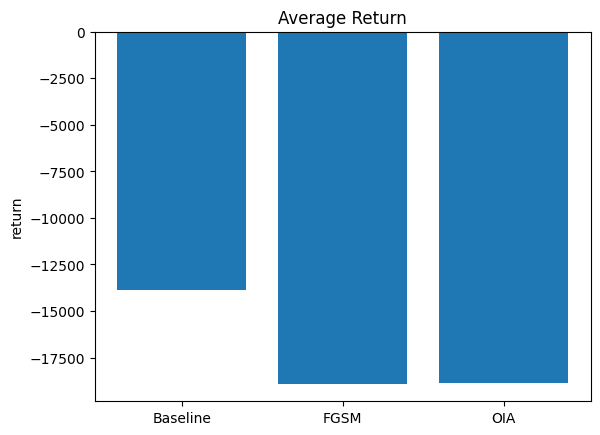

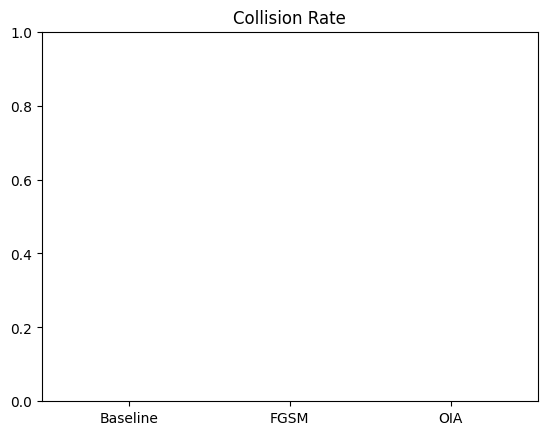

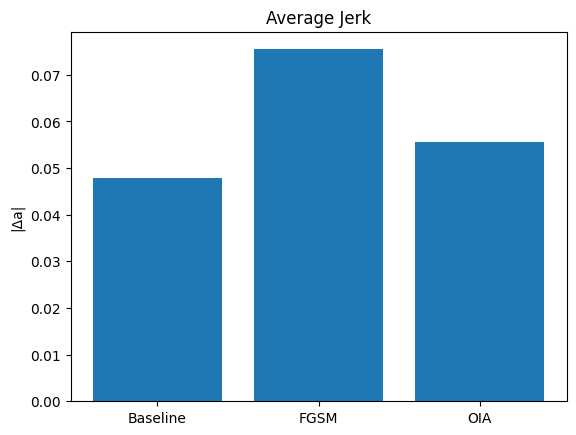

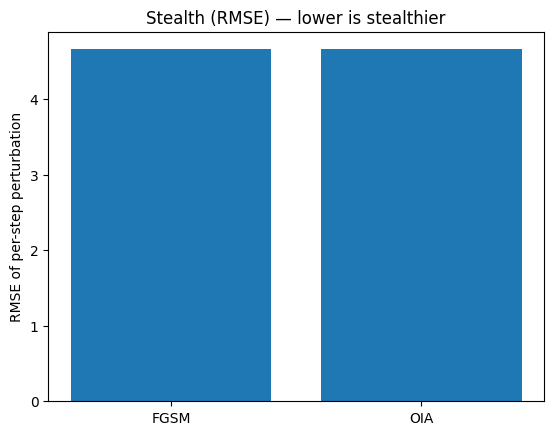

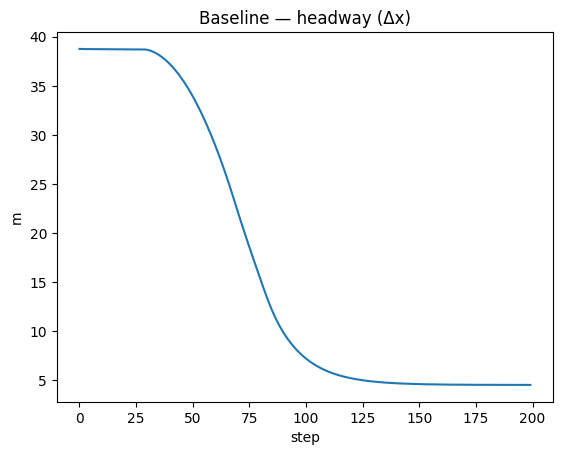

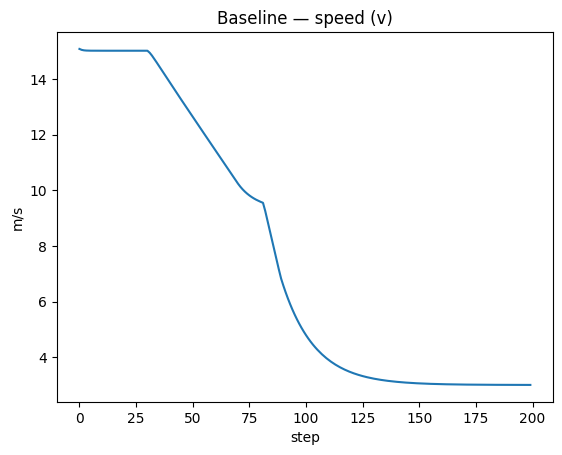

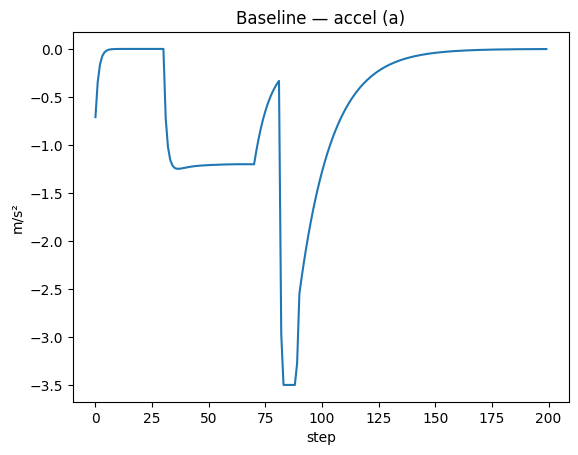

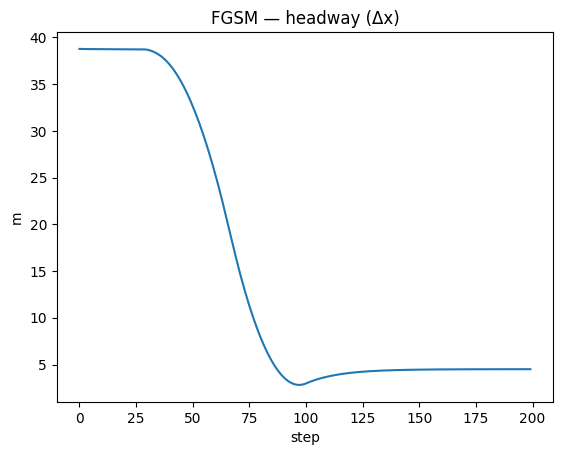

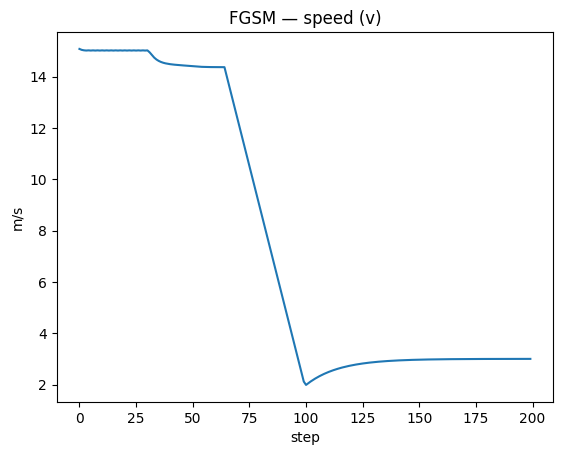

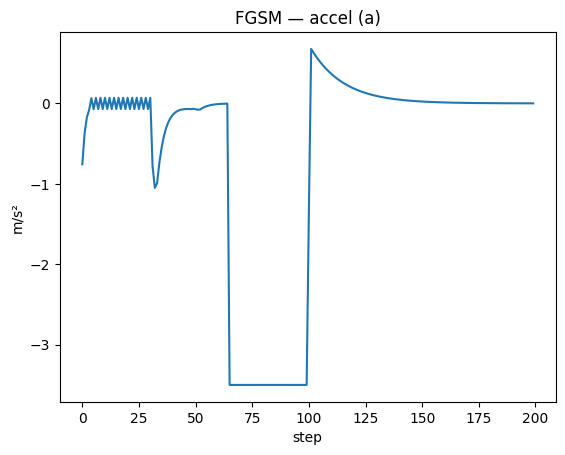

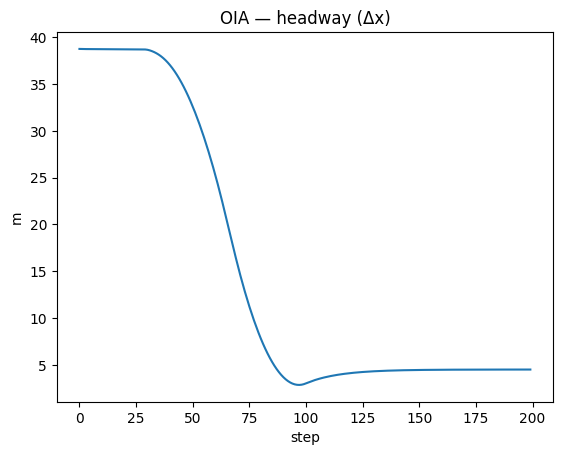

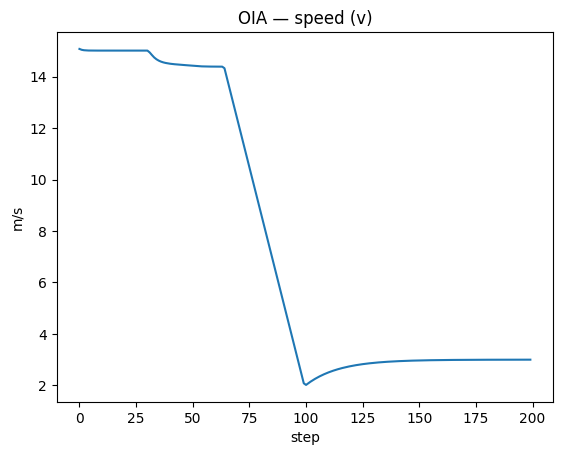

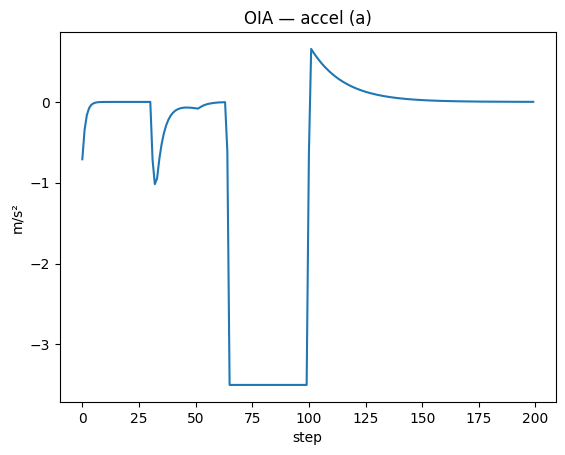


Averages across 20 episodes
Baseline : {'avg_return': -13894.104395157785, 'collision_rate': 0.0, 'avg_jerk': 0.04795805091268755}
FGSM     : {'avg_return': -18901.36142908372, 'collision_rate': 0.0, 'avg_jerk': 0.07545296545102782, 'avg_rmse': 4.658687354267554}
OIA      : {'avg_return': -18861.652475206625, 'collision_rate': 0.0, 'avg_jerk': 0.055650913836328655, 'avg_rmse': 4.659759986522077}


In [52]:
EPISODES = 20
EPS_FGSM = 0.010
EPS_OIA  = 0.020   # slightly larger to reflect OIA’s stronger impact

baseline = evaluate_condition(None,        eps=0.0,      episodes=EPISODES)
fgsm     = evaluate_condition(FGSMAttack,  eps=EPS_FGSM, episodes=EPISODES)
oia      = evaluate_condition(OIAttack,    eps=EPS_OIA,  episodes=EPISODES)

print("collisions (Baseline):", baseline["collisions"].tolist())
print("collisions (FGSM)    :", fgsm["collisions"].tolist())
print("collisions (OIA)     :", oia["collisions"].tolist())

def safe_mean(x, default=np.nan):
    x = np.asarray(x, dtype=float)
    return float(np.nanmean(x)) if x.size else float(default)

avg_return     = [safe_mean(baseline["returns"]),    safe_mean(fgsm["returns"]),    safe_mean(oia["returns"])]
collision_rate = [safe_mean(baseline["collisions"], 0.0), safe_mean(fgsm["collisions"], 0.0), safe_mean(oia["collisions"], 0.0)]
avg_jerk       = [safe_mean(baseline["jerks"]),      safe_mean(fgsm["jerks"]),      safe_mean(oia["jerks"])]
stealth_rmse   = [np.nan, safe_mean(fgsm["rmses"]),  safe_mean(oia["rmses"])]

labels = ["Baseline","FGSM","OIA"]

plt.figure(); plt.bar(labels, np.nan_to_num(avg_return,     nan=0.0)); plt.title("Average Return");   plt.ylabel("return"); plt.show()
plt.figure(); plt.bar(labels, np.nan_to_num(collision_rate, nan=0.0)); plt.title("Collision Rate");  plt.ylim(0,1);       plt.show()
plt.figure(); plt.bar(labels, np.nan_to_num(avg_jerk,       nan=0.0)); plt.title("Average Jerk");    plt.ylabel("|Δa|");  plt.show()

plt.figure(); plt.bar(["FGSM","OIA"], np.nan_to_num(stealth_rmse[1:], nan=0.0))
plt.title("Stealth (RMSE) — lower is stealthier"); plt.ylabel("RMSE of per-step perturbation"); plt.show()

def plot_traj(traj, title):
    t = np.arange(len(traj["Δx"]))
    plt.figure(); plt.plot(t, traj["Δx"]); plt.xlabel("step"); plt.ylabel("m");   plt.title(title+" — headway (Δx)"); plt.show()
    plt.figure(); plt.plot(t, traj["v"]);   plt.xlabel("step"); plt.ylabel("m/s"); plt.title(title+" — speed (v)");   plt.show()
    plt.figure(); plt.plot(t, traj["a"]);   plt.xlabel("step"); plt.ylabel("m/s²");plt.title(title+" — accel (a)");   plt.show()

plot_traj(baseline["sample"]["traj"], "Baseline")
plot_traj(fgsm["sample"]["traj"],     "FGSM")
plot_traj(oia["sample"]["traj"],      "OIA")

print("\nAverages across", EPISODES, "episodes")
print("Baseline :", {"avg_return": avg_return[0], "collision_rate": collision_rate[0], "avg_jerk": avg_jerk[0]})
print("FGSM     :", {"avg_return": avg_return[1], "collision_rate": collision_rate[1], "avg_jerk": avg_jerk[1], "avg_rmse": stealth_rmse[1]})
print("OIA      :", {"avg_return": avg_return[2], "collision_rate": collision_rate[2], "avg_jerk": avg_jerk[2], "avg_rmse": stealth_rmse[2]})
